In [175]:
%pwd

'/Users/r/Documents/stud/ss24/finnpinn/src'

In [176]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [177]:
dir_paths = [p for p in Path("../data_out/finn_running_intervals_stepsize_30").glob("finn_running_interval_*") if p.is_dir()]
dir_paths

[PosixPath('../data_out/finn_running_intervals_stepsize_30/finn_running_interval_1'),
 PosixPath('../data_out/finn_running_intervals_stepsize_30/finn_running_interval_6'),
 PosixPath('../data_out/finn_running_intervals_stepsize_30/finn_running_interval_8'),
 PosixPath('../data_out/finn_running_intervals_stepsize_30/finn_running_interval_9'),
 PosixPath('../data_out/finn_running_intervals_stepsize_30/finn_running_interval_7'),
 PosixPath('../data_out/finn_running_intervals_stepsize_30/finn_running_interval_0'),
 PosixPath('../data_out/finn_running_intervals_stepsize_30/finn_running_interval_10'),
 PosixPath('../data_out/finn_running_intervals_stepsize_30/finn_running_interval_11'),
 PosixPath('../data_out/finn_running_intervals_stepsize_30/finn_running_interval_5'),
 PosixPath('../data_out/finn_running_intervals_stepsize_30/finn_running_interval_2'),
 PosixPath('../data_out/finn_running_intervals_stepsize_30/finn_running_interval_3'),
 PosixPath('../data_out/finn_running_intervals_steps

In [178]:
df = {
    "retardation_file_paths": [],
    "interval_index": [],
    "num_epochs": [],
}
for p in dir_paths:
    all_ret_file_paths = sorted((p / "predicted_retardations").glob("retPred_*.npy"), key=lambda x: int(x.stem.split("_")[-1]))
    if not all_ret_file_paths:
        continue
    df["retardation_file_paths"].append(all_ret_file_paths[-1])
    df["interval_index"].append(int(p.name.split("_")[-1]))
    df["num_epochs"].append(int(all_ret_file_paths[-1].stem.split("_")[-1]))
df = pd.DataFrame(df).sort_values("interval_index").reset_index(drop=True)
df = df[df["interval_index"] < 7]
df = df[df["num_epochs"] >= 100].reset_index(drop=True)
df

,retardation_file_paths,interval_index,num_epochs
0,../data_out/finn_running_intervals_stepsize_30...,0,100
1,../data_out/finn_running_intervals_stepsize_30...,1,100
2,../data_out/finn_running_intervals_stepsize_30...,2,100
3,../data_out/finn_running_intervals_stepsize_30...,3,100
4,../data_out/finn_running_intervals_stepsize_30...,4,100
5,../data_out/finn_running_intervals_stepsize_30...,5,100
6,../data_out/finn_running_intervals_stepsize_30...,6,100


In [179]:
df2 = df.copy()
df2["ret"] = df["retardation_file_paths"].apply(lambda p: np.load(p).ravel())
df2 = df2.explode('ret').reset_index(drop=True)
df2["u"] = np.tile(np.arange(0, 100), len(df))
df2

,retardation_file_paths,interval_index,num_epochs,ret,u
0,../data_out/finn_running_intervals_stepsize_30...,0,100,4.927309,0
1,../data_out/finn_running_intervals_stepsize_30...,0,100,4.781768,1
2,../data_out/finn_running_intervals_stepsize_30...,0,100,4.650408,2
3,../data_out/finn_running_intervals_stepsize_30...,0,100,4.531885,3
4,../data_out/finn_running_intervals_stepsize_30...,0,100,4.424959,4
...,...,...,...,...,...
695,../data_out/finn_running_intervals_stepsize_30...,6,100,3.260319,95
696,../data_out/finn_running_intervals_stepsize_30...,6,100,3.259472,96
697,../data_out/finn_running_intervals_stepsize_30...,6,100,3.258656,97
698,../data_out/finn_running_intervals_stepsize_30...,6,100,3.25787,98


In [180]:
df2.dtypes

retardation_file_paths    object
interval_index             int64
num_epochs                 int64
ret                       object
u                          int64
dtype: object

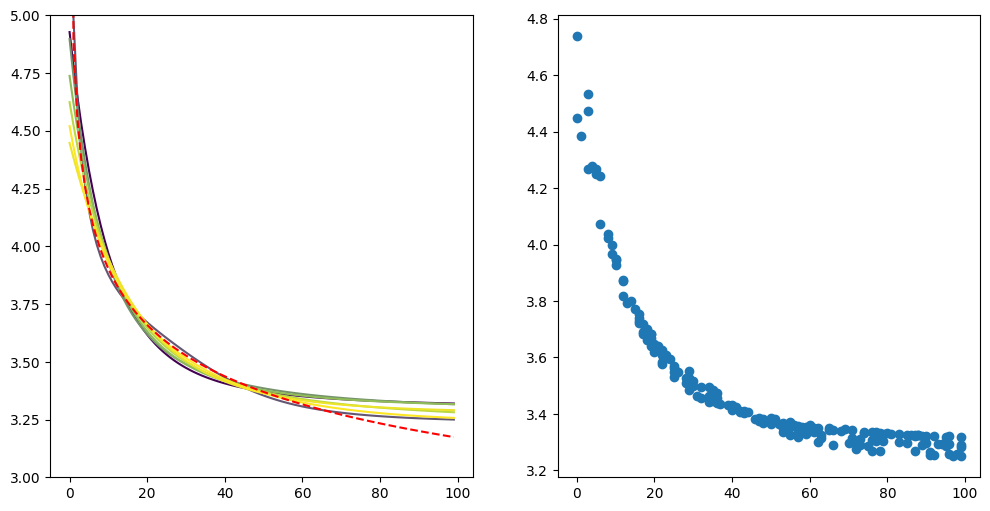

In [188]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

ret_freundlich = np.load("../data_out/retardation_freundlich.npy")

initial_colors = plt.cm.viridis(np.linspace(0, 1, len(df)))
final_color = initial_colors[-1]

highest_time_step_ret = np.load(df["retardation_file_paths"].iloc[-1])

sampled_u_indices = []
sampled_rs = []
for i, p in enumerate(df["retardation_file_paths"]):
    ret = np.load(p)

    u_index_samples = rng.choice(np.arange(0, 100), 25, replace=False)
    sampled_u_indices.extend(u_index_samples)
    sampled_rs.extend(ret[u_index_samples])

    mixed_color = initial_colors[i] * (1 - i / (len(df) - 1)) + final_color * (i / (len(df) - 1))
    ax1.plot(ret, label=f"{df['interval_index'][i]}, {df['num_epochs'][i]}", color=mixed_color)

sampled_u_indices = np.array(sampled_u_indices)
sampled_rs = np.array(sampled_rs)
ax2.plot(sampled_u_indices, sampled_rs, "o")

ax1.plot(ret_freundlich, "r--", label="freundlich")#, color=final_color)
ax1.set_ylim(3,5)
# ax.legend()
plt.show()

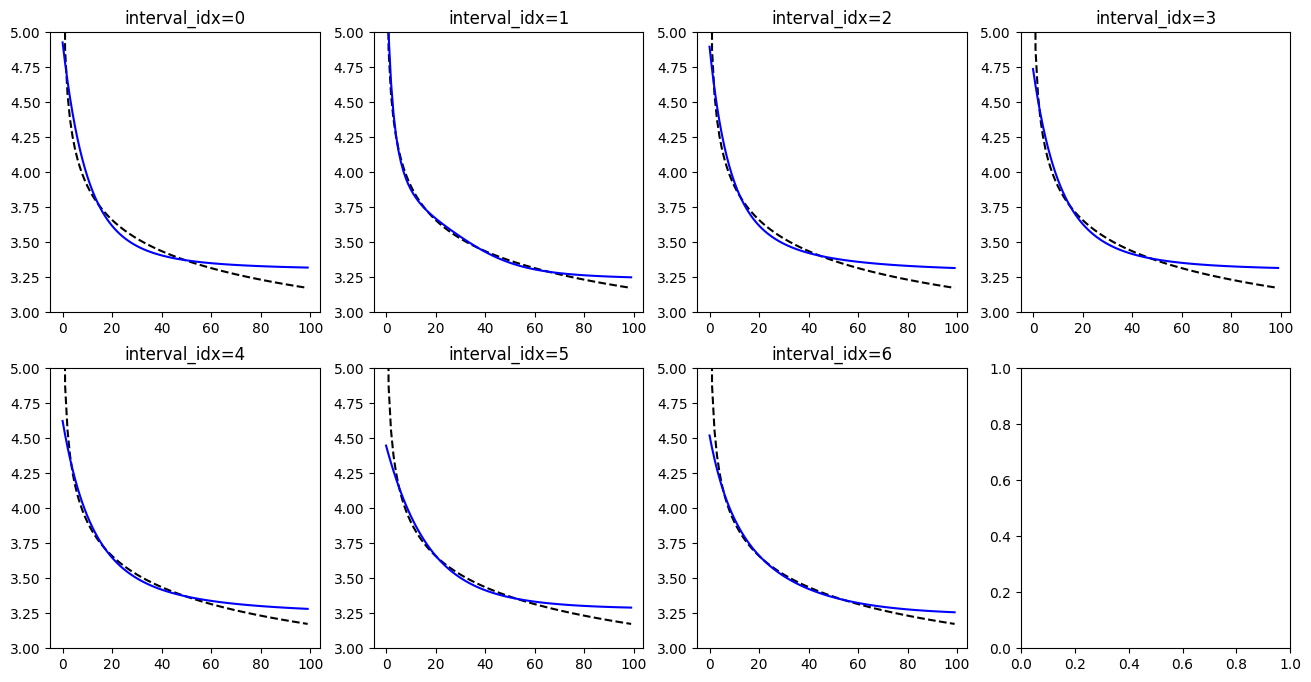

In [182]:
ret_freundlich = np.load("../data_out/retardation_freundlich.npy")

initial_colors = plt.cm.viridis(np.linspace(0, 1, len(df)))
final_color = initial_colors[-1]

ncols = 4
nrows = int(np.ceil(len(df) / ncols))
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows))
axs = axs.ravel()

for i, p, ax in zip(range(len(df)), df["retardation_file_paths"], axs):
    ret = np.load(p)
    mixed_color = initial_colors[i] * (1 - i / (len(df) - 1)) + final_color * (i / (len(df) - 1))
    interval_idx = df['interval_index'][i]
    ax.set_title(f"{interval_idx=}")
    ax.plot(ret_freundlich, "k--", label="freundlich")
    ax.plot(ret, "b-")
    ax.set_ylim(3,5)

plt.show()

# Make sub interval training data

In [183]:
# from pathlib import Path

# path = Path("../data/synthetic_data/retardation_freundlich/sub_intervals/")
# path.mkdir(exist_ok=True, parents=True)

# step_size = 30
# for i in range(10**9):
#     start = i * step_size
#     end = start + step_size
#     arr = c[start:end]
#     if len(arr) != step_size:
#         break
#     np.save(path / f"c_{i}.npy", arr)